In [1]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import shutil
from pathlib import Path
from tqdm.auto import tqdm # progress bars in notebooks
from pathlib import Path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Datasci207/audio_speech_actors_01-24"

Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


In [5]:
def consolidate_files(source_dir: str, dest_dir: str, extension: str = ".wav"):

    source_path = Path(source_dir)
    dest_path = Path(dest_dir)

    # destination directory
    dest_path.mkdir(parents=True, exist_ok=True)
    print(f"Consolidated directory is at: {dest_path.resolve()}")

    files_to_copy = list(source_path.rglob(f'*{extension}'))

    if not files_to_copy:
        print(f"No '{extension}' files found in the source directory.")
        return

    #Copy files with a tqdm progress bar
    copied_count = 0
    print(f"Found {len(files_to_copy)} files to copy...")

    for source_file in tqdm(files_to_copy, desc="Copying files", unit="file"):
        if source_file.parent.resolve() == dest_path.resolve():
            continue

        try:
            #shutil.copy2 to preserve file metadata (like timestamps)
            shutil.copy2(source_file, dest_path)
            copied_count += 1
        except Exception as e:
            print(f"\nCould not copy {source_file.name}. Error: {e}")

    print(f"\nFinished. Copied {copied_count} of {len(files_to_copy)} files.")


In [ ]:
RAV = "D:/EDFS_Data/RAVDESS/raw"
Target_dir = RAV + '/All_Actors_Speech_test'

In [7]:
# Excute only once for speech or song
consolidate_files(RAV, Target_dir, extension=".wav")

Consolidated directory is at: /content/drive/MyDrive/Datasci207/audio_speech_actors_01-24/All_Actors_Speech_test
Found 1429 files to copy...


Copying files:   0%|          | 0/1429 [00:00<?, ?file/s]


Finished. Copied 1429 of 1429 files.


In [8]:
print(f"Number of files in RAV directory: {len(list(Path(RAV).rglob('*.wav')))}")

Number of files in RAV directory: 2869


In [9]:
phrase_map = {1: "Kids are talking by the door", 2: "Dogs are sitting by the door"}

emotion_map = {
    1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}

file_paths = glob.glob(os.path.join(RAV, 'Actor_*', '*.wav'))

processed_data = []
for file_path in file_paths:
    # Get just the filename from the full path
    filename = os.path.basename(file_path)

    # Split filename to extract metadata parts
    parts = filename.split('.')[0].split('-')

    # Extract and process metadata for one file
    emotion = emotion_map[int(parts[2])]
    gender = "female" if int(parts[6]) % 2 == 0 else "male"
    phrase = phrase_map[int(parts[4])]

    # Append a dictionary with all required info to our list
    processed_data.append({
        'labels': f"{gender}_{emotion}",
        'path': file_path,
        'phrase': phrase
    })

#Create the final DataFrame from the list of dictionaries in one go
RAV_df = pd.DataFrame(processed_data)

# Display the first few rows to verify
display(RAV_df.head())

,labels,path,phrase
0,male_fear,/content/drive/MyDrive/Datasci207/audio_speech...,Kids are talking by the door
1,male_neutral,/content/drive/MyDrive/Datasci207/audio_speech...,Dogs are sitting by the door
2,male_angry,/content/drive/MyDrive/Datasci207/audio_speech...,Kids are talking by the door
3,male_disgust,/content/drive/MyDrive/Datasci207/audio_speech...,Dogs are sitting by the door
4,male_fear,/content/drive/MyDrive/Datasci207/audio_speech...,Kids are talking by the door


In [10]:
RAV_df.labels.value_counts()

,count
labels,
male_neutral,144
female_neutral,144
male_angry,96
male_disgust,96
male_surprise,96
male_fear,96
male_happy,96
male_sad,96
female_fear,96


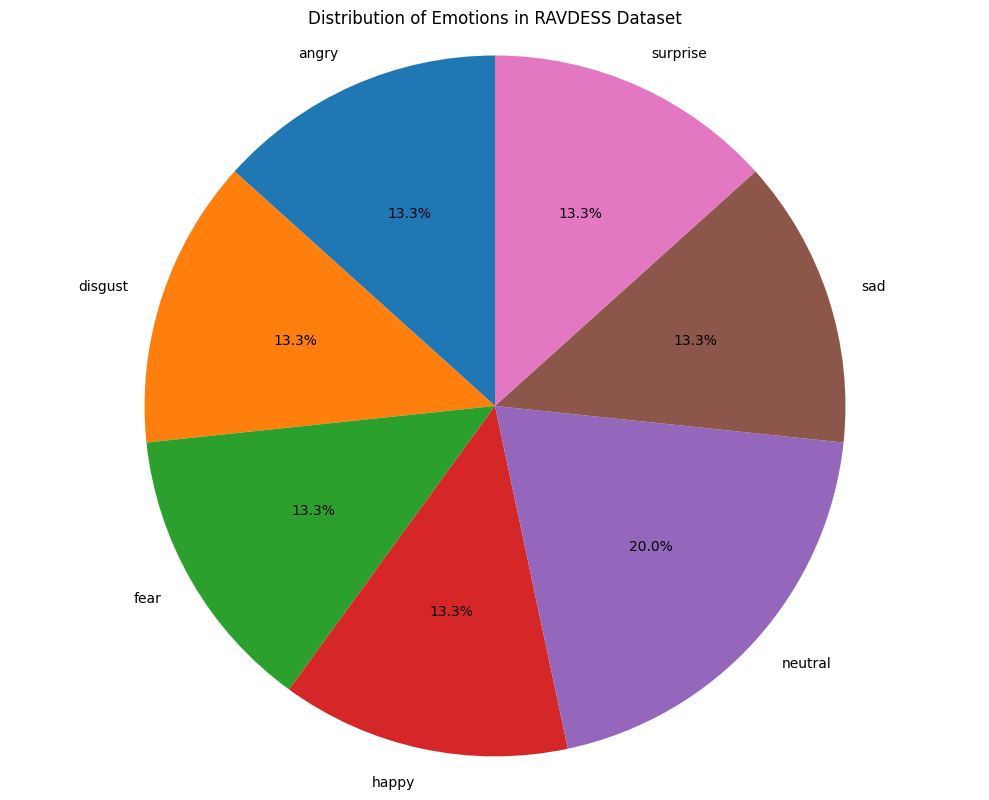

In [23]:
# Extract emotion from labels
RAV_df['emotion_split'] = RAV_df['labels'].astype(str).str.split('_').str[1]

# Group by emotion, and count the occurrences
emotion_counts = RAV_df.groupby(['emotion_split']).size()

# Plot the stacked bar chart
plt.figure(figsize=(10, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Emotions in RAVDESS Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

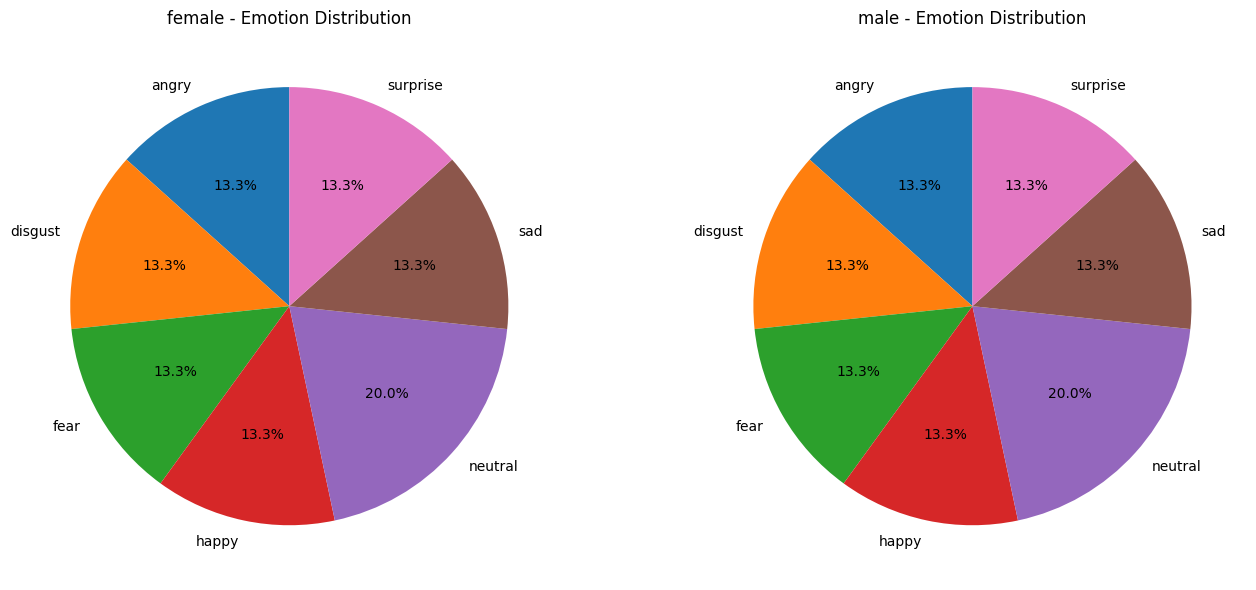

In [24]:
# Extract emotion and gender from labels
RAV_df[['gender_split', 'emotion_split']] = RAV_df['labels'].str.split('_', expand=True)

# Group by emotion and gender, and count the occurrences
emotion_gender_counts = RAV_df.groupby(['emotion_split', 'gender_split']).size().unstack(fill_value=0)

# Plot the stacked bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, gender in enumerate(emotion_gender_counts.columns):
    axes[idx].pie(emotion_gender_counts[gender], labels=emotion_gender_counts.index,
                  autopct='%1.1f%%', startangle=90)
    axes[idx].set_title(f'{gender} - Emotion Distribution')
plt.tight_layout()
plt.show()

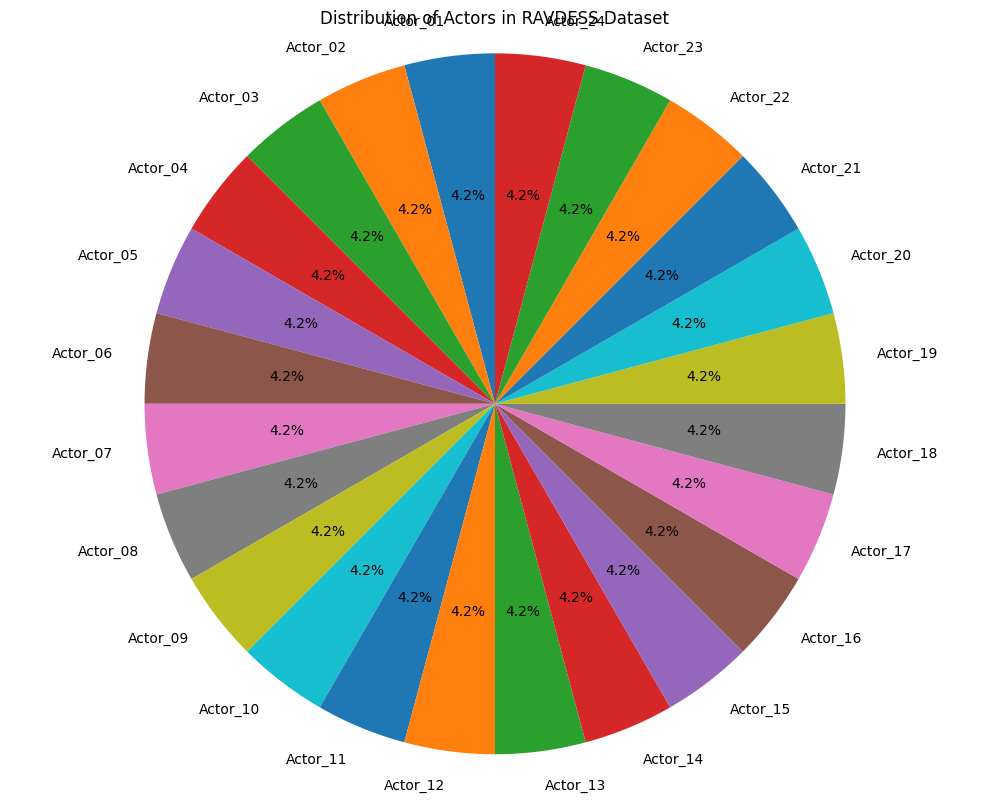

In [36]:
# Extract emotion from labels
if 'actor_id' not in RAV_df.columns:
    RAV_df['actor_id'] = RAV_df['path'].apply(lambda x: x.split('/')[-2])

# Group by emotion, and count the occurrences
actor_counts = RAV_df.groupby(['actor_id']).size()

# Plot the stacked bar chart
plt.figure(figsize=(10, 8))
plt.pie(actor_counts, labels=actor_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Actors in RAVDESS Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

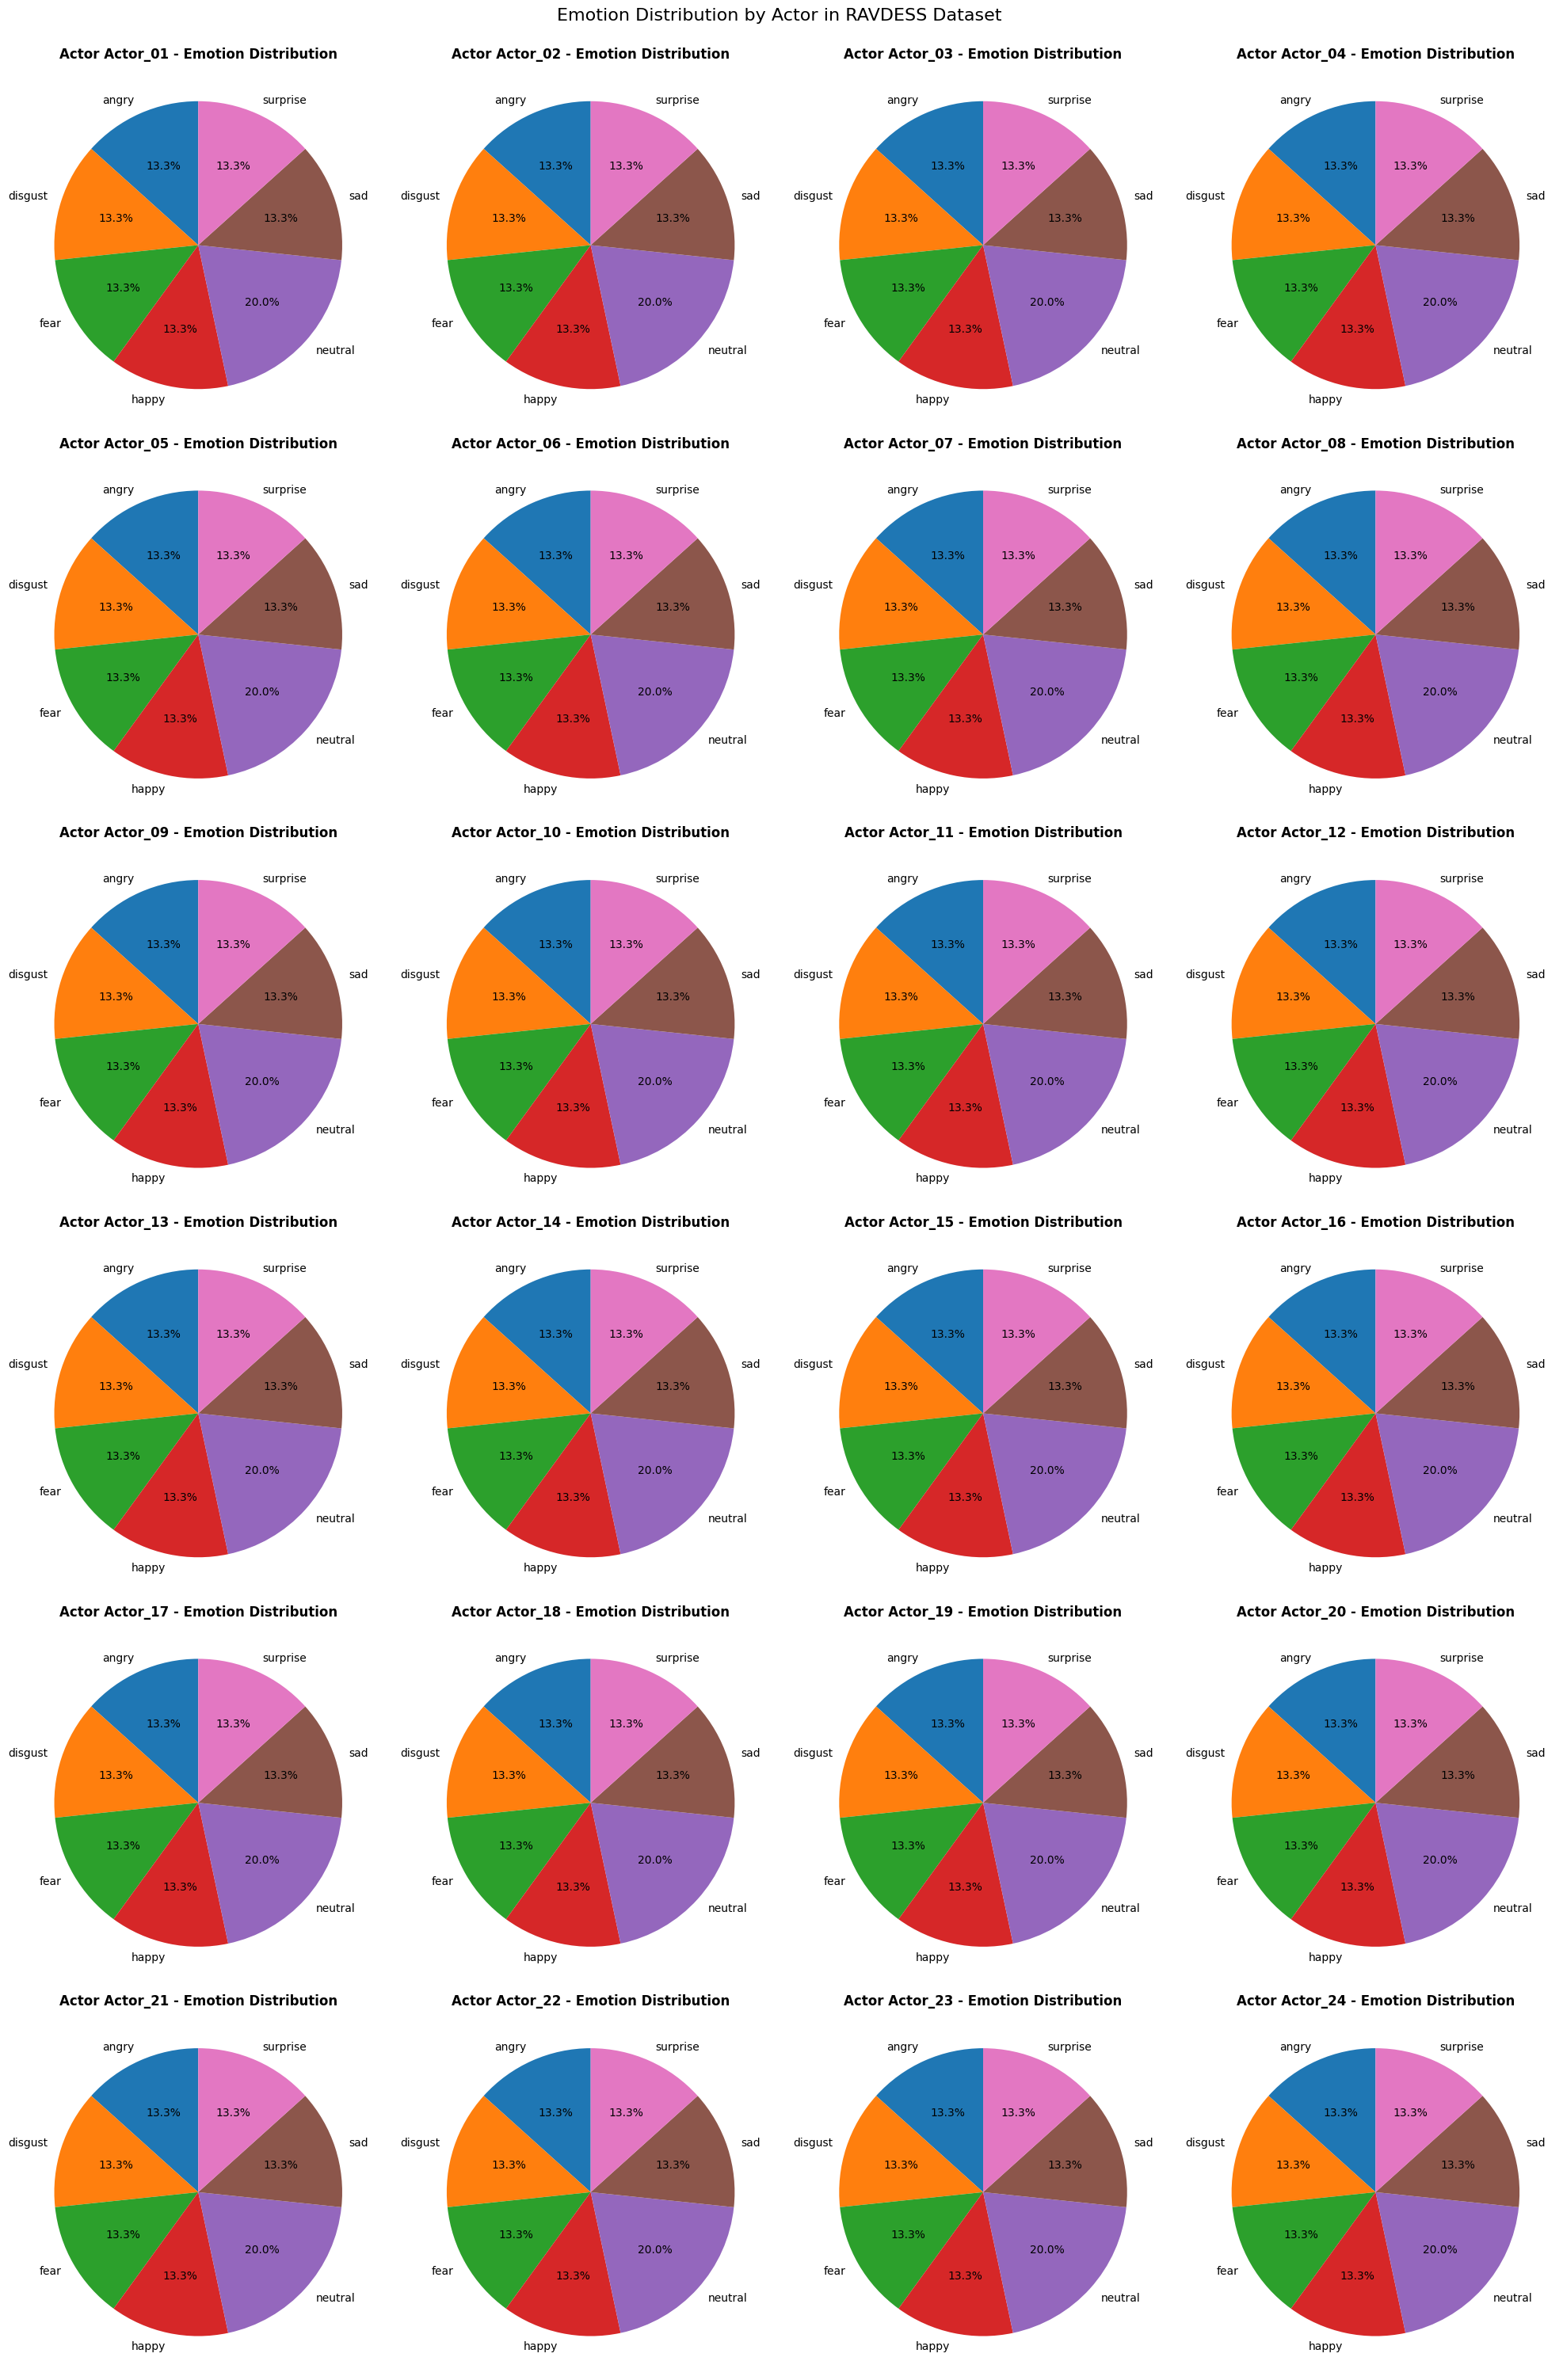

In [35]:
# Extract actor ID from the path if not already present
if 'actor_id' not in RAV_df.columns:
    RAV_df['actor_id'] = RAV_df['path'].apply(lambda x: x.split('/')[-2])

# Group by emotion and actor, and count the occurrences
emotion_actor_counts = RAV_df.groupby(['emotion_split', 'actor_id']).size().unstack(fill_value=0)

# Get number of actors and calculate grid dimensions
num_actors = len(emotion_actor_counts.columns)
n_cols = 4  # 4 pie charts per row
n_rows = (num_actors + n_cols - 1) // n_cols  # Calculate needed rows

# Plot pie charts for each actor
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for idx, actor in enumerate(emotion_actor_counts.columns):
    axes[idx].pie(emotion_actor_counts[actor], labels=emotion_actor_counts.index,
                  autopct='%1.1f%%', startangle=90)
    axes[idx].set_title(f'Actor {actor} - Emotion Distribution', fontweight='bold')

# Hide any extra subplots
for idx in range(num_actors, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Emotion Distribution by Actor in RAVDESS Dataset', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

<Figure size 1200x1500 with 0 Axes>

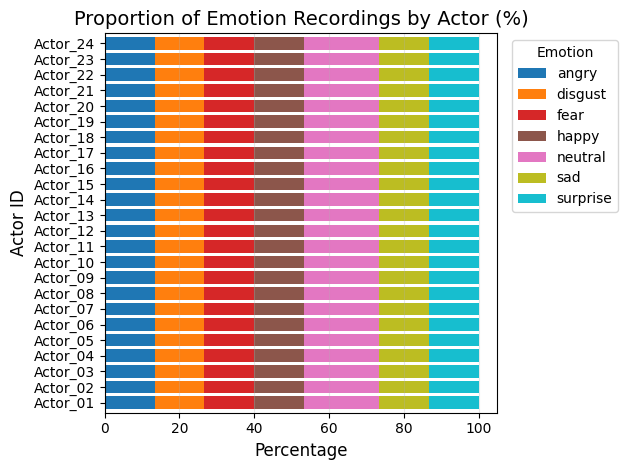

In [34]:
# Extract actor ID from the path
RAV_df['actor_id'] = RAV_df['path'].apply(lambda x: x.split('/')[-2])

# Extract emotion from labels if not already present (assuming the format is gender_emotion)
if 'emotion_split' not in RAV_df.columns:
  RAV_df[['gender_split', 'emotion_split']] = RAV_df['labels'].str.split('_', expand=True)

# Group by actor and emotion, and count the occurrences
actor_emotion_counts = RAV_df.groupby(['actor_id', 'emotion_split']).size().unstack(fill_value=0)

# Plot the stacked bar chart
plt.figure(figsize=(12, 15))
actor_emotion_pct.plot(kind='barh', stacked=True, colormap='tab10', width=0.8)
plt.title('Proportion of Emotion Recordings by Actor (%)', fontsize=14)
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Actor ID', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

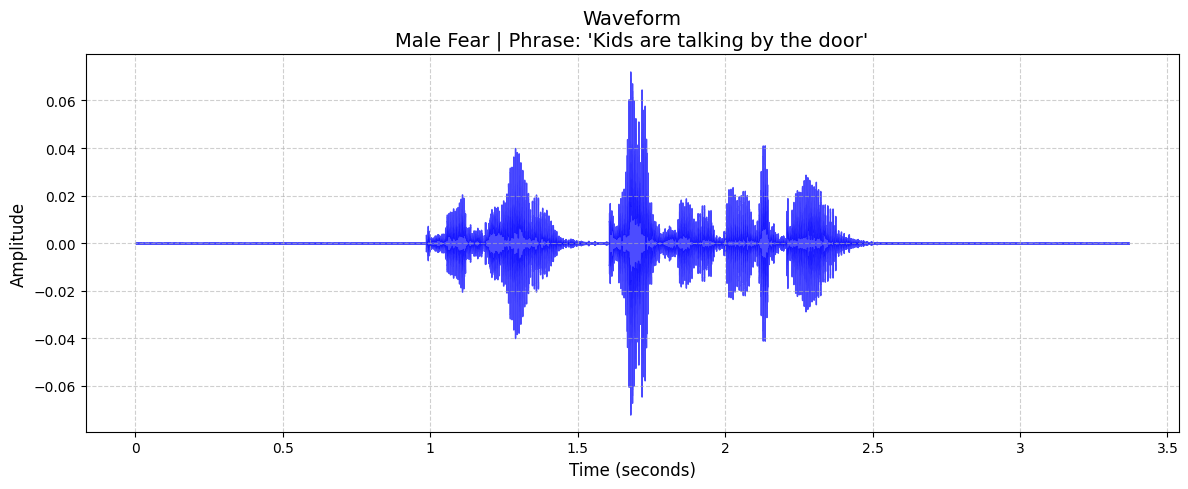

In [13]:
#sample file to plot
sample_file = RAV_df.iloc[10]
file_path = sample_file['path']
label = sample_file['labels'].replace('_', ' ').title() # Format for title
phrase = sample_file['phrase']

# Load the audio file using librosa. 'y' is the audio time series, and 'sr' is the sampling rate
y, sr = librosa.load(file_path)

# Create the plot
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y, sr=sr, color='blue', alpha=0.7)

# Set the title and labels
plt.title(f"Waveform\n{label} | Phrase: '{phrase}'", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

# Play the audio
ipd.Audio(data=y, rate=sr)

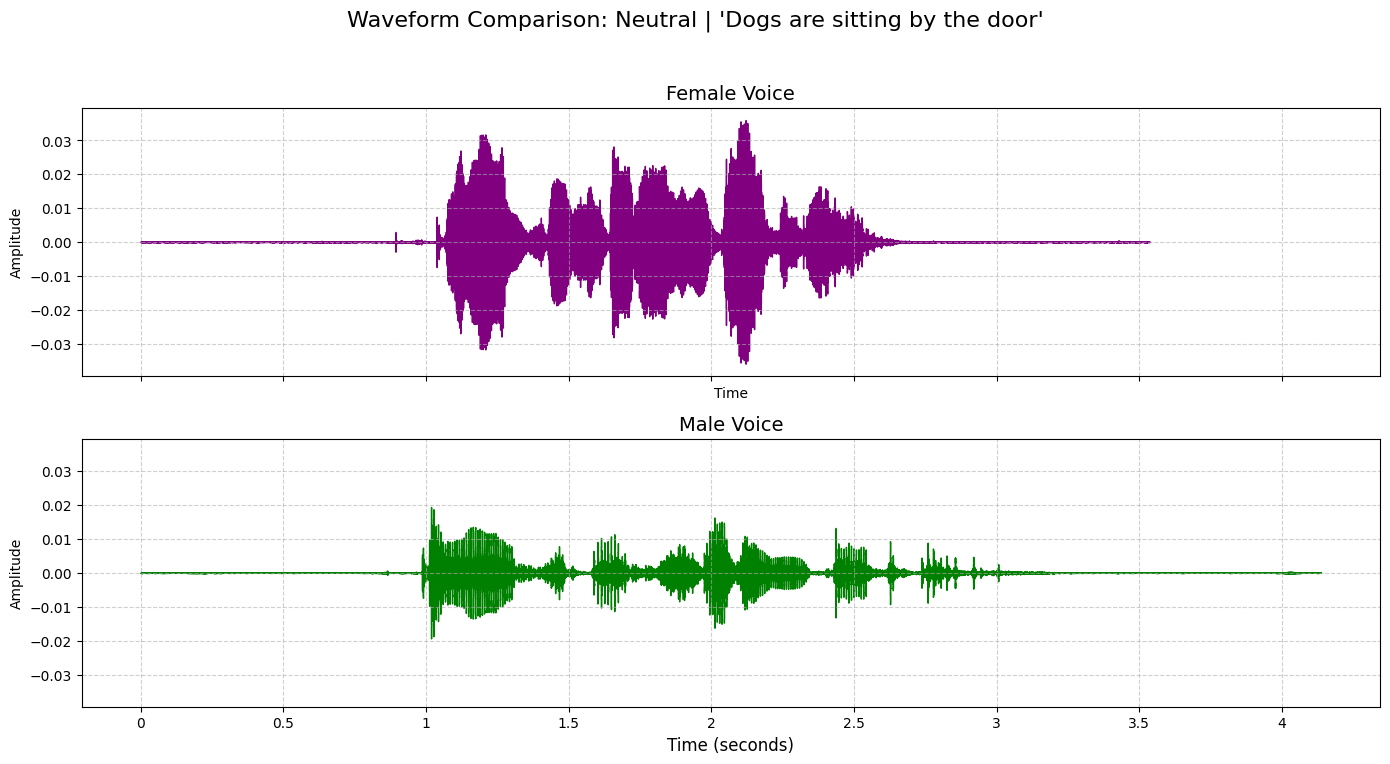

In [37]:
female_sample = RAV_df[(RAV_df['labels'] == 'female_neutral') & (RAV_df['phrase'].str.contains("Dogs"))].iloc[0]
male_sample = RAV_df[(RAV_df['labels'] == 'male_neutral') & (RAV_df['phrase'] == female_sample['phrase'])].iloc[0]

# Load the audio files
y_female, sr_female = librosa.load(female_sample['path'])
y_male, sr_male = librosa.load(male_sample['path'])

## Plotting the Waveforms
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle(f"Waveform Comparison: Neutral | '{female_sample['phrase']}'", fontsize=16)

# Plot Female Waveform
librosa.display.waveshow(y_female, sr=sr_female, ax=axes[0], color='purple')
axes[0].set_title("Female Voice", fontsize=14)
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Male Waveform
librosa.display.waveshow(y_male, sr=sr_male, ax=axes[1], color='green')
axes[1].set_title("Male Voice", fontsize=14)
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for the main title
plt.show()

Found 14 gender-emotion combinations for phrase containing 'Dogs'
   gender_split emotion_split
0        female         angry
1        female       disgust
2        female          fear
3        female         happy
4        female       neutral
5        female           sad
6        female      surprise
7          male         angry
8          male       disgust
9          male          fear
10         male         happy
11         male       neutral
12         male           sad
13         male      surprise


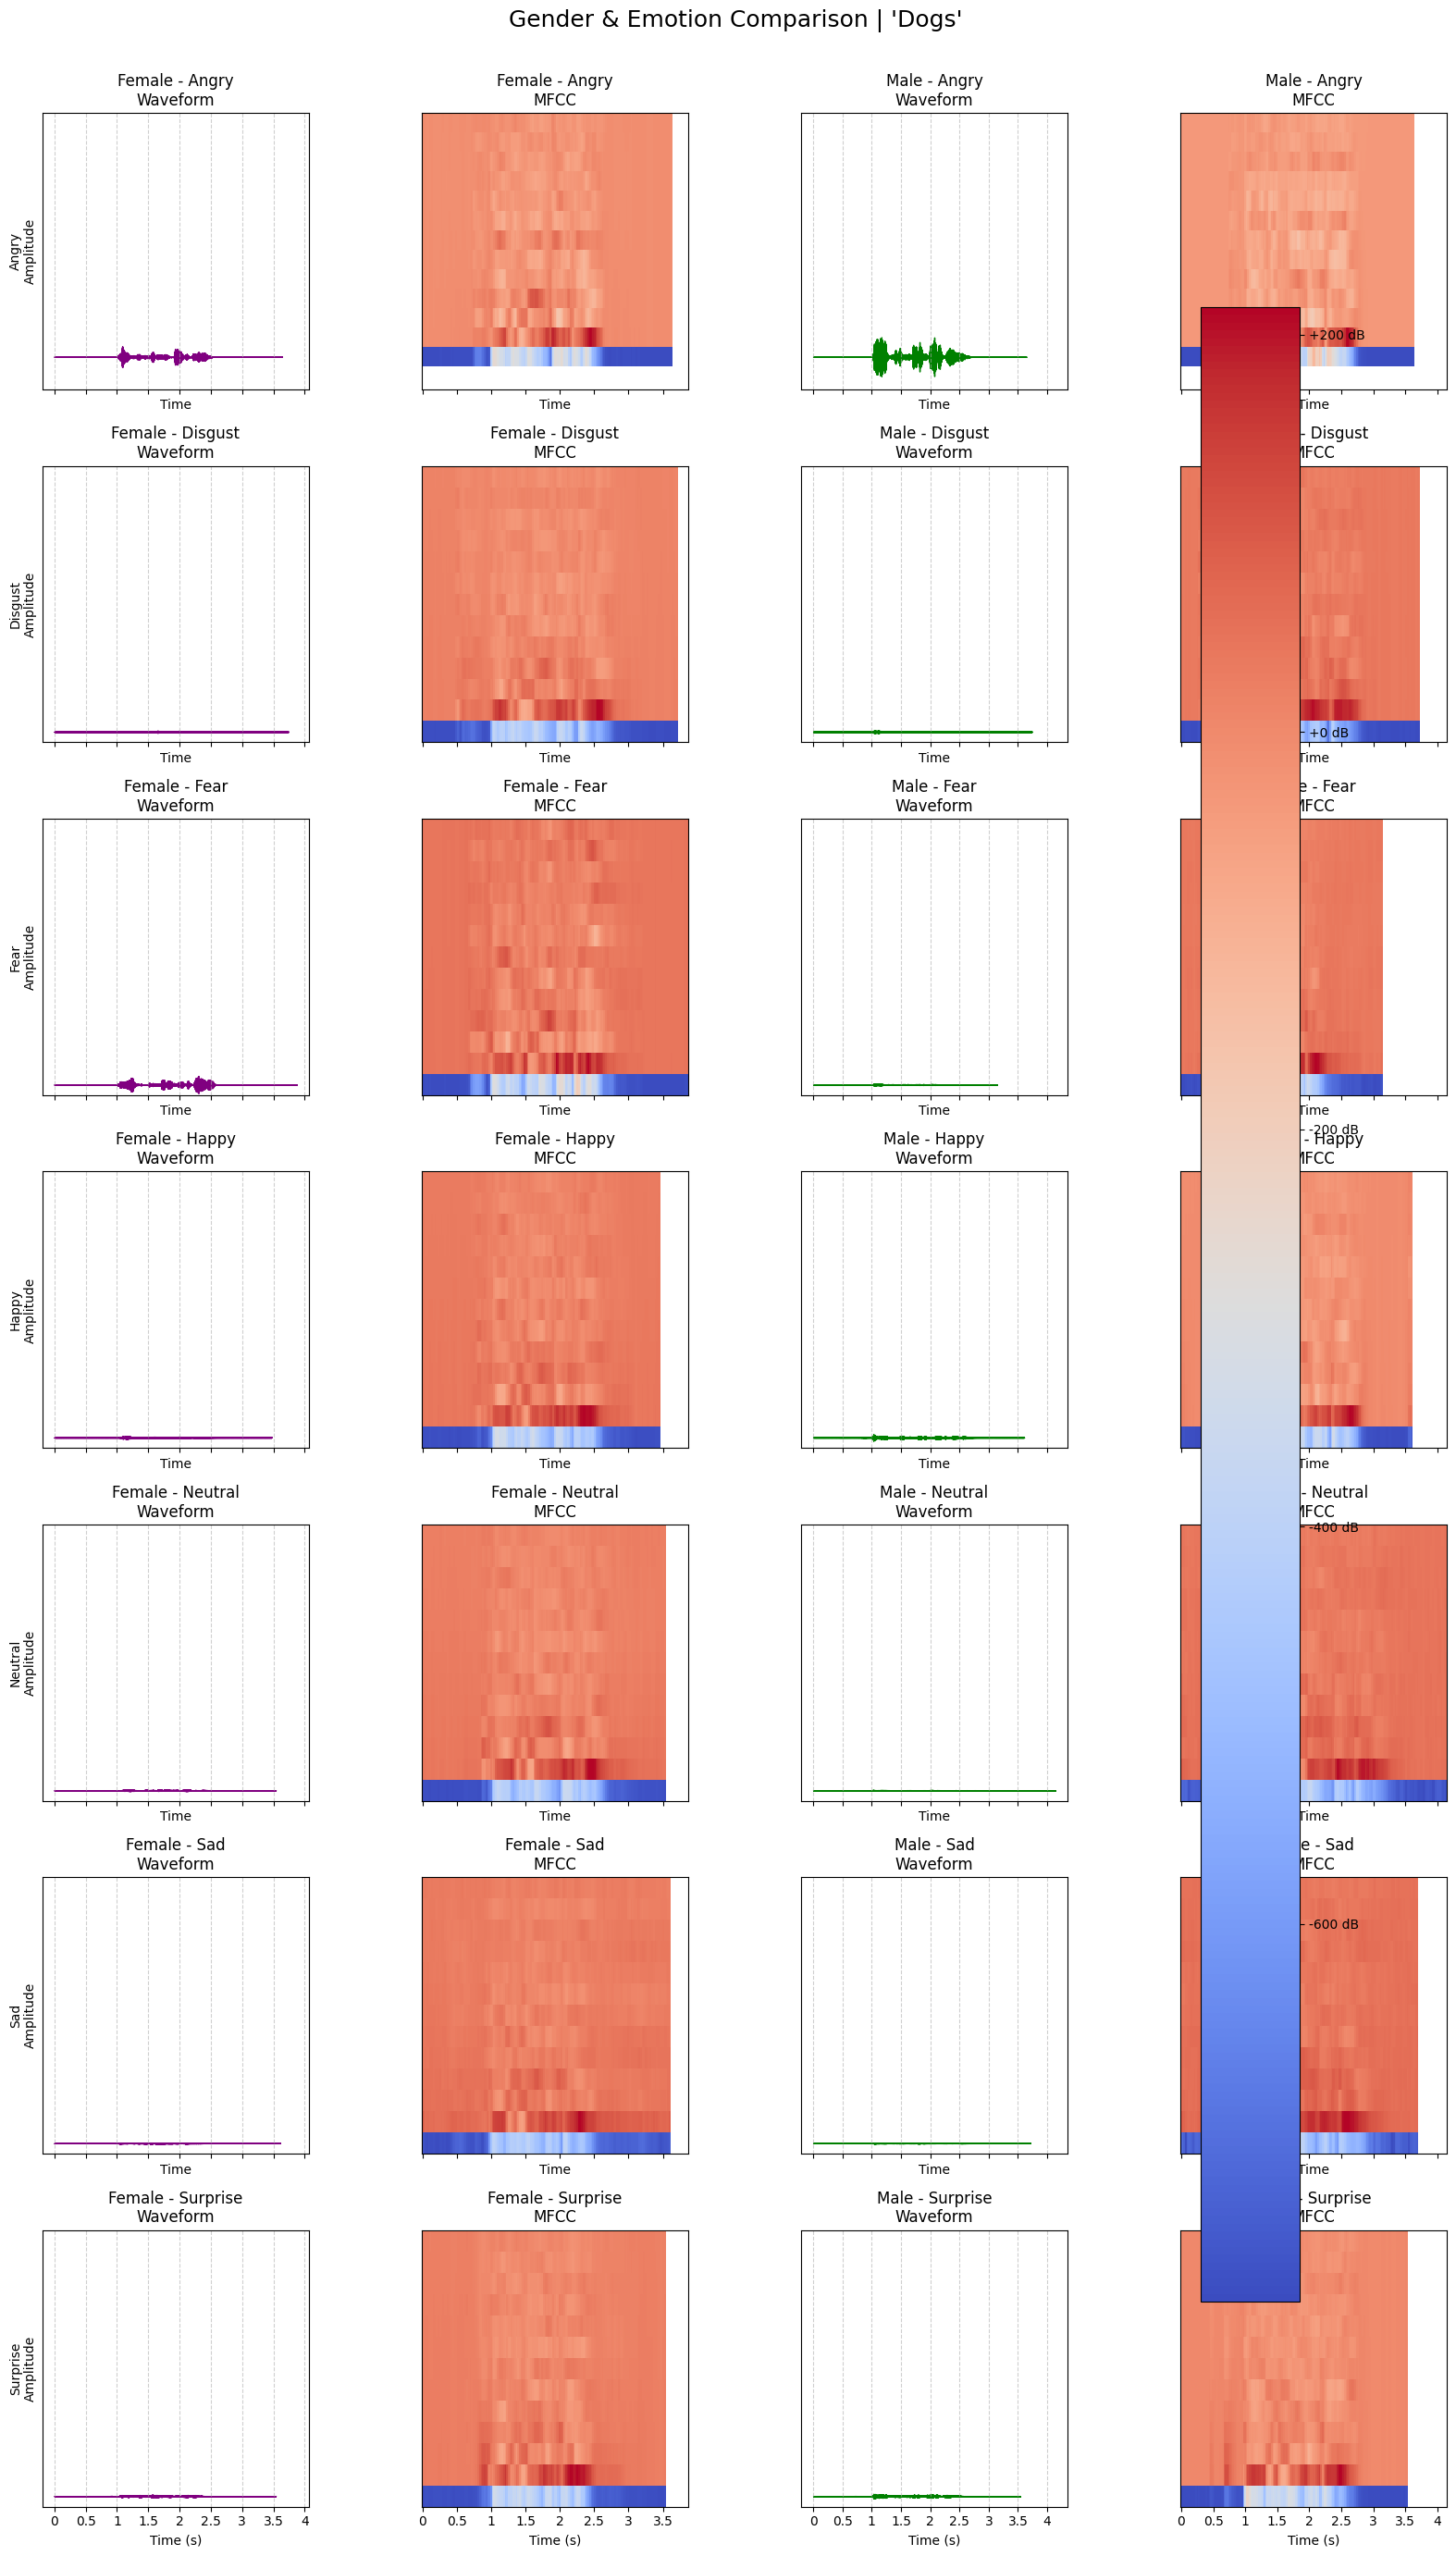

In [31]:
# Select a phrase to compare across both genders and emotions
selected_phrase = "Dogs"

# Get all available gender-emotion combinations for this phrase
available_samples = RAV_df[RAV_df['phrase'].str.contains(selected_phrase)]
gender_emotion_combos = available_samples.groupby(['gender_split', 'emotion_split']).first().reset_index()

print(f"Found {len(gender_emotion_combos)} gender-emotion combinations for phrase containing '{selected_phrase}'")
print(gender_emotion_combos[['gender_split', 'emotion_split']])

# Get unique genders and emotions
genders = sorted(gender_emotion_combos['gender_split'].unique())
emotions = sorted(gender_emotion_combos['emotion_split'].unique())

# Create a grid: rows = emotions, columns = genders * 2 (waveform + MFCC for each gender)
num_emotions = len(emotions)
num_genders = len(genders)
cols = num_genders * 2  # Each gender gets 2 columns (waveform + MFCC)
rows = num_emotions

fig, axes = plt.subplots(rows, cols, figsize=(8*num_genders, 4*num_emotions),
                         sharex='col', sharey='row')
fig.suptitle(f"Gender & Emotion Comparison | '{selected_phrase}'", fontsize=18, y=0.995)

# Ensure axes is 2D even if there's only one row
if rows == 1:
    axes = axes.reshape(1, -1)

for emotion_idx, emotion in enumerate(emotions):
    for gender_idx, gender in enumerate(genders):
        # Get sample for this gender-emotion combination
        sample = gender_emotion_combos[
            (gender_emotion_combos['gender_split'] == gender) &
            (gender_emotion_combos['emotion_split'] == emotion)
        ]

        if len(sample) == 0:
            # No sample for this combination
            waveform_col = gender_idx * 2
            mfcc_col = gender_idx * 2 + 1
            axes[emotion_idx, waveform_col].text(0.5, 0.5, 'No Data',
                                                  ha='center', va='center', fontsize=12)
            axes[emotion_idx, mfcc_col].text(0.5, 0.5, 'No Data',
                                              ha='center', va='center', fontsize=12)
            axes[emotion_idx, waveform_col].set_title(f"{gender.capitalize()} - {emotion.capitalize()}")
            continue

        sample = sample.iloc[0]

        # Load audio
        y, sr = librosa.load(sample['path'])
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Column indices for this gender
        waveform_col = gender_idx * 2
        mfcc_col = gender_idx * 2 + 1

        # Color coding: different color for each gender
        color = 'purple' if gender == 'female' else 'green'

        # Waveform
        librosa.display.waveshow(y, sr=sr, ax=axes[emotion_idx, waveform_col], color=color)
        axes[emotion_idx, waveform_col].set_title(f"{gender.capitalize()} - {emotion.capitalize()}\nWaveform")
        axes[emotion_idx, waveform_col].grid(True, linestyle='--', alpha=0.6)

        # Add ylabel only for first column
        if gender_idx == 0:
            axes[emotion_idx, waveform_col].set_ylabel(f"{emotion.capitalize()}\nAmplitude", fontsize=10)

        # MFCC
        img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[emotion_idx, mfcc_col])
        axes[emotion_idx, mfcc_col].set_title(f"{gender.capitalize()} - {emotion.capitalize()}\nMFCC")

        # Add xlabel only for bottom row
        if emotion_idx == rows - 1:
            axes[emotion_idx, waveform_col].set_xlabel("Time (s)")
            axes[emotion_idx, mfcc_col].set_xlabel("Time (s)")

# Add a single colorbar for all MFCC plots
mfcc_axes = [axes[i, j] for i in range(rows) for j in range(1, cols, 2)]
fig.colorbar(img, ax=mfcc_axes, format='%+2.0f dB', pad=0.01)

plt.tight_layout(rect=[0, 0.01, 0.99, 0.99])
plt.show()

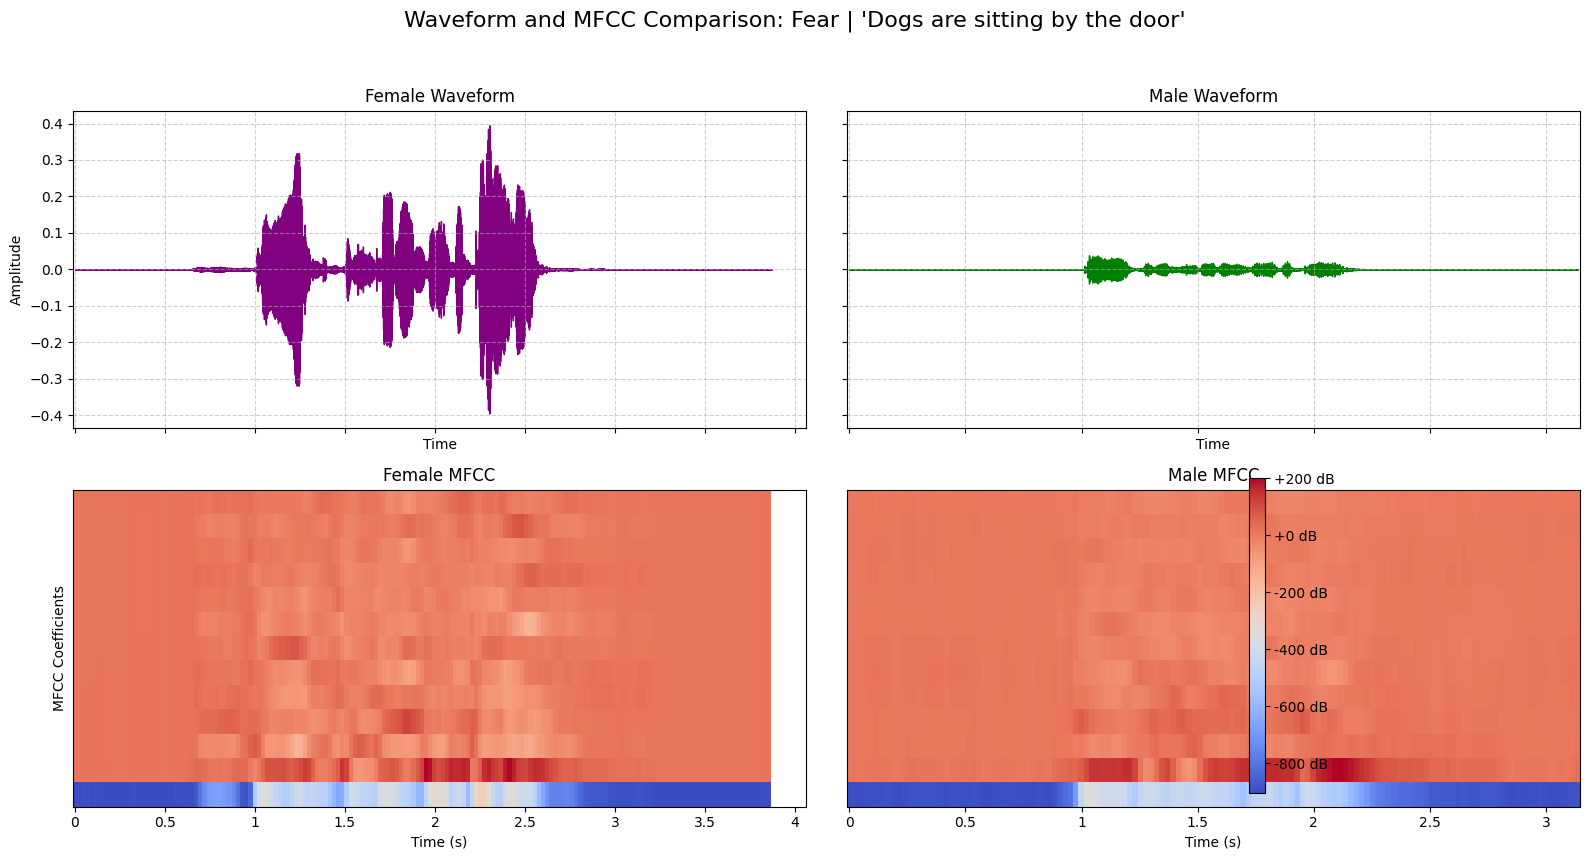

In [38]:

female_sample = RAV_df[(RAV_df['labels'] == 'female_fear') & (RAV_df['phrase'].str.contains("Dogs"))].iloc[0]
male_sample = RAV_df[(RAV_df['labels'] == 'male_fear') & (RAV_df['phrase'] == female_sample['phrase'])].iloc[0]

# Load the audio data
y_female, sr_female = librosa.load(female_sample['path'])
y_male, sr_male = librosa.load(male_sample['path'])

# MFCCs for both audio files
mfccs_female = librosa.feature.mfcc(y=y_female, sr=sr_female, n_mfcc=13)
mfccs_male = librosa.feature.mfcc(y=y_male, sr=sr_male, n_mfcc=13)

# Create the 2x2 plot grid
# sharex='col' and sharey='row' link the axes for easier comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex='col', sharey='row')
fig.suptitle(f"Waveform and MFCC Comparison: Fear | '{female_sample['phrase']}'", fontsize=16)

## --- Top Row: Waveforms ---
librosa.display.waveshow(y_female, sr=sr_female, ax=axes[0, 0], color='purple')
axes[0, 0].set_title("Female Waveform")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

librosa.display.waveshow(y_male, sr=sr_male, ax=axes[0, 1], color='green')
axes[0, 1].set_title("Male Waveform")
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

## --- Bottom Row: MFCCs ---
img1 = librosa.display.specshow(mfccs_female, sr=sr_female, x_axis='time', ax=axes[1, 0])
axes[1, 0].set_title("Female MFCC")
axes[1, 0].set_ylabel("MFCC Coefficients")
axes[1, 0].set_xlabel("Time (s)")

img2 = librosa.display.specshow(mfccs_male, sr=sr_male, x_axis='time', ax=axes[1, 1])
axes[1, 1].set_title("Male MFCC")
axes[1, 1].set_xlabel("Time (s)")

# Add a single, shared colorbar for both MFCC plots
fig.colorbar(img2, ax=[axes[1, 0], axes[1, 1]], format='%+2.0f dB')

# Adjust layout to prevent titles from overlapping and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

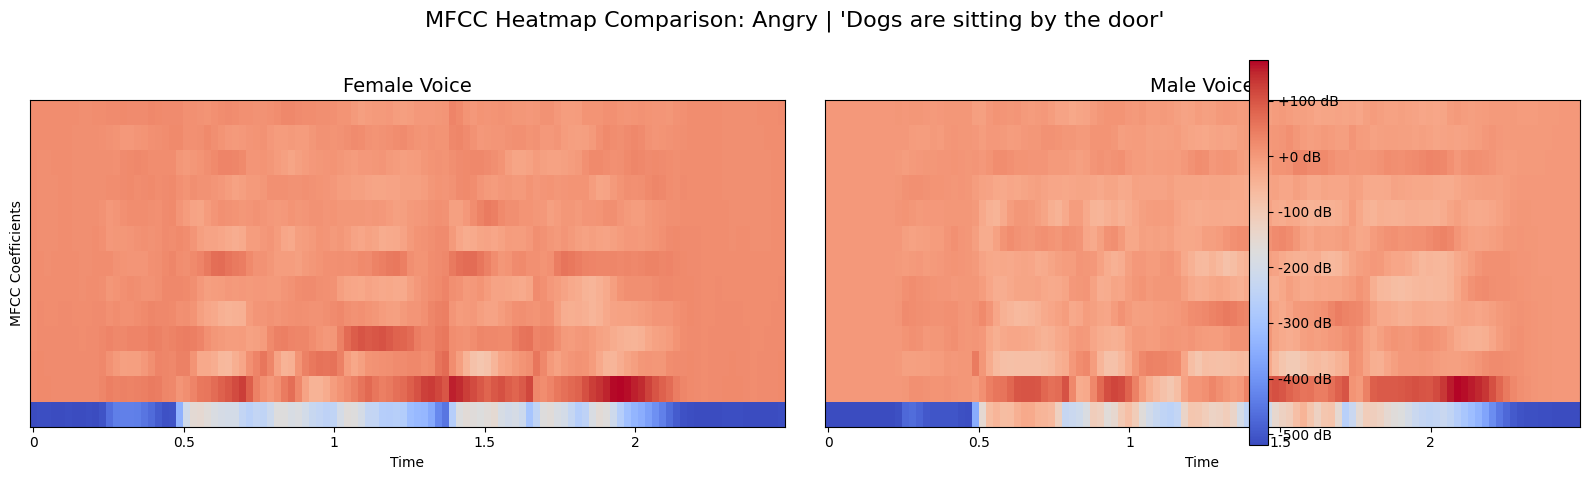

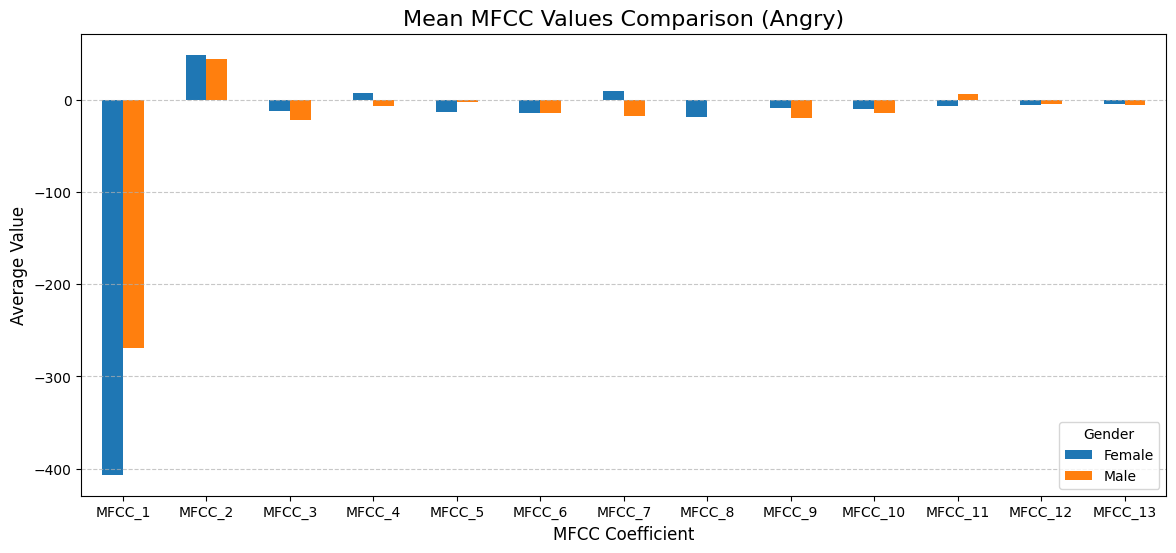

In [16]:
female_sample = RAV_df[(RAV_df['labels'] == 'female_angry') & (RAV_df['phrase'].str.contains("Dogs"))].iloc[0]
male_sample = RAV_df[(RAV_df['labels'] == 'male_angry') & (RAV_df['phrase'] == female_sample['phrase'])].iloc[0]

# Reusable function to load audio and extract MFCCs
def get_mfccs(path, sr=22050, n_mfcc=13, duration=2.5):
    y, sr = librosa.load(path, sr=sr, duration=duration, offset=0.5)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Extract MFCCs for both files
female_mfccs = get_mfccs(female_sample['path'])
male_mfccs = get_mfccs(male_sample['path'])

## Visualization 1: Side-by-Side MFCC Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
fig.suptitle(f"MFCC Heatmap Comparison: Angry | '{female_sample['phrase']}'", fontsize=16)

# Plot Female MFCC
librosa.display.specshow(female_mfccs, sr=22050, x_axis='time', ax=axes[0])
axes[0].set_title("Female Voice", fontsize=14)
axes[0].set_ylabel("MFCC Coefficients")

# Plot Male MFCC
img = librosa.display.specshow(male_mfccs, sr=22050, x_axis='time', ax=axes[1])
axes[1].set_title("Male Voice", fontsize=14)

# Add a colorbar to the figure
fig.colorbar(img, ax=axes, format='%+2.0f dB')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

## Visualization 2: Bar Chart of Averaged MFCCs
# average the MFCCs over the time axis (axis=1)
female_mfccs_mean = np.mean(female_mfccs, axis=1)
male_mfccs_mean = np.mean(male_mfccs, axis=1)

# DataFrame for easy plotting
df_mfcc_mean = pd.DataFrame({
    'Female': female_mfccs_mean,
    'Male': male_mfccs_mean,
}, index=[f'MFCC_{i}' for i in range(1, 14)])

# Plot the bar chart
df_mfcc_mean.plot(kind='bar', figsize=(14, 6), rot=0)
plt.title("Mean MFCC Values Comparison (Angry)", fontsize=16)
plt.xlabel("MFCC Coefficient", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
def extract_features(audio_path):
    try:
        # Load audio file and resample
        X, sample_rate = librosa.load(audio_path, sr=22050)

        # Silence Trimming
        y_trimmed, _ = librosa.effects.trim(X, top_db=20)

        # Normalization
        y_normalized = librosa.util.normalize(y_trimmed)

        # MFCCs
        mfccs = np.mean(librosa.feature.mfcc(y=y_normalized, sr=sample_rate, n_mfcc=40).T, axis=0)

        # Mel Spectrogram
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y_normalized, sr=sample_rate).T, axis=0)

        # Chroma Features
        chroma = np.mean(librosa.feature.chroma_stft(y=y_normalized, sr=sample_rate).T, axis=0)

        return np.concatenate((mfccs, mel_spectrogram, chroma))

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Apply feature extraction to the DataFrame
features = RAV_df['path'].apply(extract_features)

# Remove rows where feature extraction failed
RAV_df['features'] = features
RAV_df = RAV_df.dropna(subset=['features'])

# DataFrame with features as columns
features_df = pd.DataFrame(RAV_df['features'].values.tolist())

# Concatenate with the original DataFrame (excluding the original 'features' list column)
RAV_df = pd.concat([RAV_df.drop('features', axis=1), features_df], axis=1)

display(RAV_df.head())

,labels,path,phrase,gender_split,emotion_split,actor_id,0,1,2,3,...,170,171,172,173,174,175,176,177,178,179
0,male_fear,/content/drive/MyDrive/Datasci207/audio_speech...,Kids are talking by the door,male,fear,Actor_05,-183.261200,100.231316,-2.248539,18.420414,...,0.315625,0.355372,0.395147,0.320458,0.331522,0.516889,0.405649,0.382899,0.362670,0.268001
1,male_neutral,/content/drive/MyDrive/Datasci207/audio_speech...,Dogs are sitting by the door,male,neutral,Actor_05,-204.394974,109.878487,14.988119,30.941561,...,0.342502,0.461544,0.380471,0.312726,0.342150,0.371125,0.315358,0.369496,0.537279,0.557035
2,male_angry,/content/drive/MyDrive/Datasci207/audio_speech...,Kids are talking by the door,male,angry,Actor_05,-123.472992,70.277168,-38.383144,2.056171,...,0.494154,0.590074,0.618450,0.391212,0.247971,0.243468,0.265285,0.271031,0.327524,0.387946
3,male_disgust,/content/drive/MyDrive/Datasci207/audio_speech...,Dogs are sitting by the door,male,disgust,Actor_05,-219.780045,87.030655,12.450661,22.594278,...,0.329400,0.393629,0.510397,0.550687,0.500054,0.394523,0.455070,0.452323,0.428424,0.410011
4,male_fear,/content/drive/MyDrive/Datasci207/audio_speech...,Kids are talking by the door,male,fear,Actor_05,-143.552124,62.601479,-39.420525,-1.306770,...,0.433300,0.319277,0.253968,0.231314,0.297317,0.242947,0.128702,0.224315,0.284557,0.391485
